# Initial imports

In [13]:
import pickle
import numpy as np
import scipy.sparse as ss
import datetime
import matplotlib.pyplot as plt
#### IMPORT DATA ####

data_source = 'TrainSet2014_3.pkl'
#data_source = 'CompetitionSet2017_3.pkl'

full_dynamic_graph_sparse, unconnected_vertex_pairs, year_start, years_delta = pickle.load(open( data_source, "rb" ) )

NUM_OF_VERTICES = 64719 # number of vertices of the semantic net
NUM_OF_EDGES    = full_dynamic_graph_sparse[:, 0].size

# Building unweighted adjacency matrix

In [2]:
# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)

adjM = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

#### BUILD DEGREE VECTOR ####

degree_vec = np.asarray(adjM.sum(1)).flatten()

print("Imported", data_source)
print("\nBuilt adjacency matrix with:")
print(" - ", NUM_OF_VERTICES, " vertices")
print(" - ", NUM_OF_EDGES, " edges\n")
print("Found ", np.count_nonzero(degree_vec == 0)," unconnected nodes.")

Imported TrainSet2014_3.pkl

Built adjacency matrix with:
 -  64719  vertices
 -  2278611  edges

Found  27230  unconnected nodes.


# Analyzing the links to be predicted

In this challenge we are tasked with ordering a list of 1 million pairs of nodes according to which pairs are most likely to appear. To get a better intuition on how to build our model, it is useful to do some preliminary analysis on the network. We start by checking how each pair of nodes is currently connected to the network.

In [3]:
pred_degree0 = degree_vec[unconnected_vertex_pairs[:,0]]
pred_degree1 = degree_vec[unconnected_vertex_pairs[:,1]]

# Counts how many links between two nodes with k = 0:
k0 = np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between one nodes with k = 0 and one k > 0:
k1 = np.count_nonzero(pred_degree0 * pred_degree1 == 0) - np.count_nonzero((pred_degree0 + pred_degree1) == 0)
# Counts how many links between two nodes with k > 0:
k2 = np.count_nonzero((pred_degree0 * pred_degree1) > 0)

print("Out of 1.000.000 new links:")
print(k0," are between two vertices with k = 0;")
print(k1," are between one vertex with k = 0 and one with k > 0;")
print(k2," are between two vertices with k > 0s;")

Out of 1.000.000 new links:
265966  are between two vertices with k = 0;
500060  are between one vertex with k = 0 and one with k > 0;
233974  are between two vertices with k > 0s;


Both in the training and competition data there is a significant number of links to be predicted between pairs where at least one of the nodes is disconnected from the network.

# Data analysis

In this section we analyze the date with the goal of finding a few traditional principles underlying the data structure. The degree distribution of complex network usually follows power law [] 
\begin{equation}
P(k)\propto k^{-\gamma},
\end{equation}
with $\gamma<2$. $2<\gamma<3$ are comum values, and it is a region of interest since the second moment of the distribution diverges []. Networks with $\gamma\leq 2$ are well defined given that in such scenario the average degree diverges.  

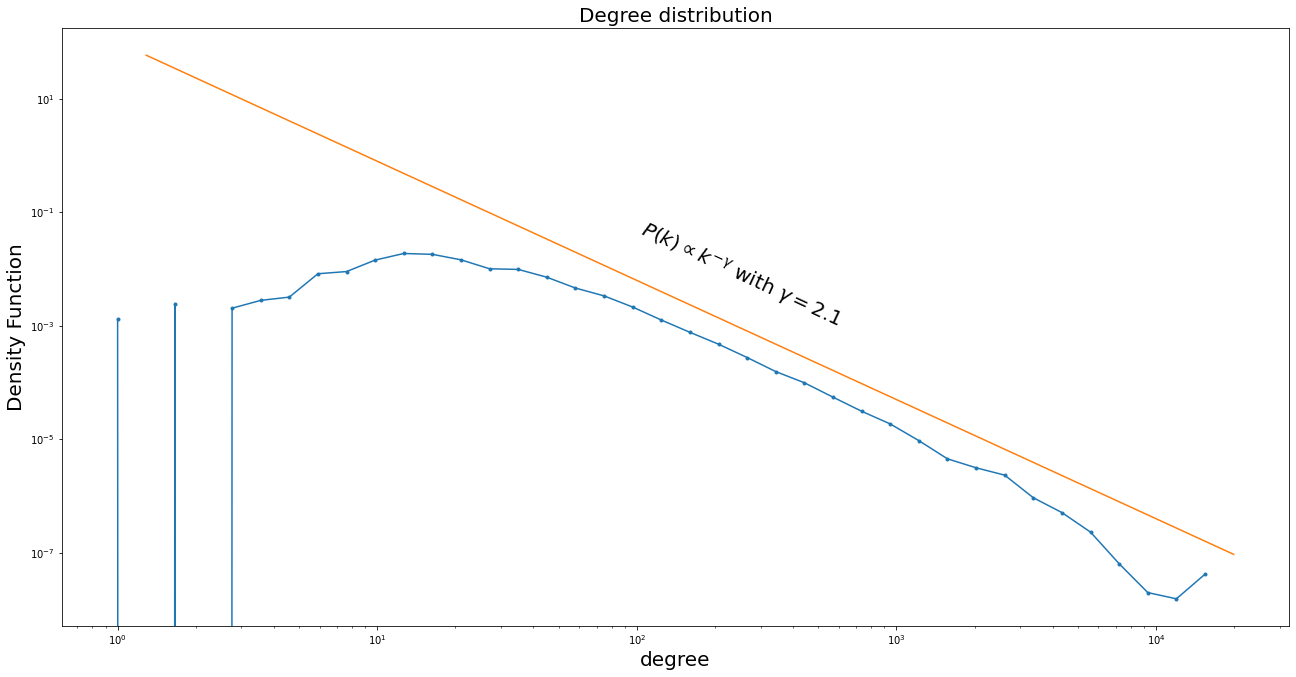

In [47]:
bins=np.logspace(np.log10(1), np.log10(max(degree_vec)+0.001), num=40);

[Y,X]=np.histogram(degree_vec,bins=bins,density=True);

plt.clf();
plt.rcParams['figure.figsize'] = [22, 11]
plt.title('Degree distribution',fontsize=20);
plt.loglog(X[0:-1],Y,'.-');
#plt.loglog(X[1:],10**(2.5)*X[1:]**(-2.3));
plt.loglog(X[1:],10**(2)*X[1:]**(-2.1));
plt.ylabel(r'Density Function',fontsize=20);
plt.xlabel(r'degree',fontsize=20);
plt.annotate(r'$P(k)\propto k^{-\gamma}$ with $\gamma=2.1$',xy=(100, 0.001),rotation=-25,fontsize=20);
plt.show(); 

# Defining simple prediction methods

### L3 Method

In [4]:
def l3_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    # Building D^-1/2.
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    degree_vec = np.where(degree_vec == 0, 1, degree_vec) # to avoid division by 0
    sqrt_degree_vec    = 1/np.sqrt(degree_vec)
    sqrt_degree_matrix = ss.diags(sqrt_degree_vec, 0)

    # Computing Ã
    adjM_tilde = sqrt_degree_matrix*adjM*sqrt_degree_matrix;
    
    # Select rows and columns of A corresponding to links to score
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    # Computing P
    p_matrix = (adjM[rows,:]*adjM_tilde*adjM[:,cols]); #adjM*
    
    # Note that p_matrix has dimensions size(rows)*size(rows). As it happens in the data from the
    # competition the indices in unconnected_vertex_pairs actually only go up to size(rows), which means
    # that we can use those same indices to call values from p_matrix. If that were not the case,
    # we would have to implement a dictionary here to correct the indices before calling values from
    # p_matrix. I checked and in the competition data the same thing happens, and so I didn't implement
    # the dictionary.
    
    # Ordering relevant scores
    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

### Common Neighbours

In [5]:
def cn_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    # Select rows and columns of A corresponding to links to score
    rows = np.unique(links_to_score[:,0])
    cols = np.unique(links_to_score[:,1])
    
    # Computing P
    p_matrix = adjM[rows,:]*adjM[:,cols];
    
    # Note that p_matrix has dimensions size(rows)*size(rows). As it happens in the data from the
    # competition the indices in unconnected_vertex_pairs actually only go up to size(rows), which means
    # that we can use those same indices to call values from p_matrix. If that were not the case,
    # we would have to implement a dictionary here to correct the indices before calling values from
    # p_matrix. I checked and in the competition data the same thing happens, and so I didn't implement
    # the dictionary.
    
    # Ordering relevant scores
    score_list = np.array(p_matrix[links_to_score[:,0], links_to_score[:,1]]).flatten()
    
    return score_list/max(score_list)

### Preferential Attachment

In [6]:
def pa_method(adjM, links_to_score):
    # adjM is assumed to be a sparse matrix
    # links_to_score is a list of pairs of nodes (v1, v2)
    # returns a list of scores for each pair in links_to_score
    
    degree_vec = np.asarray(adjM.sum(1)).flatten()
    
    score_list = degree_vec[links_to_score[:,0]] + degree_vec[links_to_score[:,1]]
    
    return score_list/max(score_list)

# Testing the methods on the training data

Skip to the end if running on the competition data.

In [7]:
print(datetime.datetime.now().time())

print("Computing L3 scores...")

score_list_l3 = l3_method(adjM, unconnected_vertex_pairs)

print("Done!")

print("Computing CN scores...")

score_list_cn = cn_method(adjM, unconnected_vertex_pairs)

print("Done!")

print("Computing PA scores...")

score_list_pa = pa_method(adjM, unconnected_vertex_pairs)

print("Done!")

print(datetime.datetime.now().time())

17:29:57.320549
Computing L3 scores...
Done!
Computing CN scores...
Done!
Computing PA scores...
Done!
17:30:18.575451


## AUC function (for 2014 -> 2017 predictions)

In [8]:
import matplotlib.pyplot as plt

def calculate_ROC(data_vertex_pairs, data_solution, show_plot = False):
    data_solution = np.array(data_solution)
    data_vertex_pairs_sorted = data_solution[data_vertex_pairs]
    
    xpos=[0]
    ypos=[0]
    ROC_vals=[]
    for ii in range(len(data_vertex_pairs_sorted)):
        if data_vertex_pairs_sorted[ii]==1:
            xpos.append(xpos[-1])
            ypos.append(ypos[-1]+1)
        if data_vertex_pairs_sorted[ii]==0:
            xpos.append(xpos[-1]+1)
            ypos.append(ypos[-1])      
            ROC_vals.append(ypos[-1])
    
    ROC_vals=np.array(ROC_vals)/max(ypos)
    ypos=np.array(ypos)/max(ypos)
    xpos=np.array(xpos)/max(xpos)
    
    if show_plot == True:
        plt.plot(xpos, ypos)
        plt.show()
    
    AUC = sum(ROC_vals)/len(ROC_vals)
    return AUC

In [54]:
# Besides the function above we can also use the one from scikit-learn
from sklearn.metrics import roc_auc_score

with open('TrainSet2014_3_solution.pkl', "rb" ) as pkl_file:
        unconnected_vertex_pairs_solution = pickle.load(pkl_file)

ground_truth = np.array(unconnected_vertex_pairs_solution)

# The tutorial AUC function uses the array of sorted indices:
sorted_predictions_l3 = np.argsort(-1.0*score_list_l3)
sorted_predictions_cn = np.argsort(-1.0*score_list_cn)
sorted_predictions_pa = np.argsort(-1.0*score_list_pa)

AUC_L3 = calculate_ROC(sorted_predictions_l3, ground_truth, False)
AUC_CN = calculate_ROC(sorted_predictions_cn, ground_truth, False)
AUC_PA = calculate_ROC(sorted_predictions_pa, ground_truth, False)

# The scikit-learn AUC function uses the array of scores directly:
AUC_L3_sk = roc_auc_score(ground_truth, score_list_l3)
AUC_CN_sk = roc_auc_score(ground_truth, score_list_cn)
AUC_PA_sk = roc_auc_score(ground_truth, score_list_pa)

print("Training data AUC:\n")
print("Using tutorial AUC function:")
print("- L3 Method: ", AUC_L3)
print("- CN Method: ", AUC_CN)
print("- PA Method: ", AUC_PA)
print("\nUsing scikit-learn AUC function, which is much faster:")
print("- L3 Method: ", AUC_L3_sk)
print("- CN Method: ", AUC_CN_sk)
print("- PA Method: ", AUC_PA_sk)

Training data AUC:

Using tutorial AUC function:
- L3 Method:  0.6928035870074668
- CN Method:  0.6940861916230197
- PA Method:  0.8038421610708972

Using scikit-learn AUC function, which is much faster:
- L3 Method:  0.6892063232508768
- CN Method:  0.6890970042220121
- PA Method:  0.8029338991694484


From the results obtained we can conclude two things:
- There is no difference between using the second or third power of the adjacency matrix. This indicates the path-based structures in the network are not very well defined, and both methods are identifying similar structures. We should also note that in the training data only about 25% of the links to be predicted are between two nodes with k > 0, which are the only pairs that get scored by powers of the adjacency matrix.

- Following the previous point and our analysis of the degree distribution, it makes sense that the preferential attachment method is the one with the best performance. Using that method our scores are directly proportional to the degree of the nodes, which is in line with the heavy scale-freeness we observed. Furthermore, given that 50% of the links to be scored in the training data are between a pair of nodes with k = 0 and k > 0, this method has an advantage by also including those pairs in the ordering.

## Combining results

Let us now see if we can get even better results by combining two of the previous methods with a greedy parameter search. We considered the combination of Common Neighbours with Preferential Attachment. We already saw that PA alone is the best performing method, but this method is completely independent of the node distance inside the network. We now test if the addition of a contribution given by the number of common neighbours is able to improve over PA. We define:

$$scores = a \times scores_\text{CN} + (1-a) \times scores_\text{PA}$$

And search for the optimal "a" between 0 and 1.

In [55]:
step   = 0.01
a_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores = a*score_list_cn + (1-a)*score_list_pa
    AUC = roc_auc_score(ground_truth, combined_scores)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()

print("Found max AUC",AUC_save[max_AUC_pos, 1],"for a =",AUC_save[max_AUC_pos, 0])

Found max AUC 0.8085615450037189 for a = 0.93


As we can see, adding a contribution of CN over the PA scores gets us a slight increase in the AUC.

# Building a time-weighted adjacency matrix

So far we have completely ignored the time stamps attached to each link in the data. These time stamps correspond to the date when each link was added to the network, counted as the total number of days since a reference date. In order to include this information in the model, we chose to use this information directly as a weight on each link. We consider the following hypothesis:

- The most important links are the very old ones and the very recent ones. The reasoning is that very old links correspond to early connections between concepts, which have had a lot of time to mature and become rooted in the field. The very recent links correspond to the latest connections between concepts, corresponding to the current hot-topic being studied in the field.

In order to quantify and test this hypothesis we normalized the time stamp to a value t between 0 and 1, and tested different functions f(t) producing weights in the links. With a bit of manual optimization we found a polynomial function producing good results, which indeed follows our hypothesis.

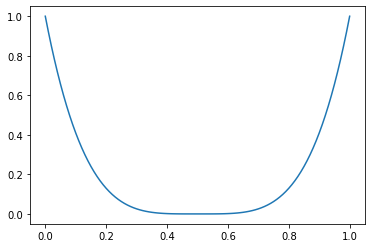

In [62]:
def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

a  = 2
x0 = 0.0
x1 = 0.5
b  = 4

# Normalizing the time-stamps
times = full_dynamic_graph_sparse[:, 2]
t     = times/times.max()

# Polynomial function of the time-stamps
times_norm = polynomial(t, x0, x1, a, b)
times_norm = np.concatenate([times_norm, times_norm])

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

delta = 0.01
x = np.arange(0, 1+delta, delta)
plt.plot(x , polynomial(x, x0, x1, a, b))

Now we simply need to run the previous methods with this modified input. Let's test the PA method.

In [61]:
print("Computing PA scores...")

score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)

AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)

print("Using scikit-learn AUC function:")
print("- PA Method: ", AUC_PA_sk_time)

Computing PA scores...
Using scikit-learn AUC function:
- PA Method:  0.8135498061387667


The time-weights also improve the results on the PA method. Now we see if we can get better than this with a grid search on a more general polynomial:

In [13]:
def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

non_zero  = 0.001
delta_a   = 1.0
delta_x0  = 0.1
delta_x1  = 0.01

b_range  = np.arange(1, 11, 1)
a_range  = np.arange(1, 5 + delta_a, delta_a)
x0_range = np.arange(0.0 + non_zero, 0.5 + non_zero + delta_x0, delta_x0)
x1_range = np.arange(0.45, 0.55, delta_x1)

AUC_save = []

for b in b_range:
    print("Current power:",b)
    for x0 in x0_range:
        for a in a_range:
            for b in b_range:
                        
                times_norm = polynomial(t, x0, x1, a, b)
                times_norm = np.concatenate([times_norm, times_norm])
                adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))
                score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)
                AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)
                        
                AUC_save.append([AUC_PA_sk_time, x0, x1, a, b])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,0].argmax()

print("Found max AUC", AUC_save[max_AUC_pos, 0],"for:")
print(AUC_save[max_AUC_pos, 1:5])

Current power: 1
Current power: 2
Current power: 3
Current power: 4
Current power: 5
Current power: 6
Current power: 7
Current power: 8
Current power: 9
Current power: 10
Found max AUC 0.8138381919270135 for:
[1.e-03 5.e-01 5.e+00 7.e+00]


In [224]:
print(AUC_save[max_AUC_pos, 1:5])

[1.0e-03 4.8e-01 5.0e+00 7.0e+00]


Using scikit-learn AUC function:
- PA Method:  0.8143095234156017


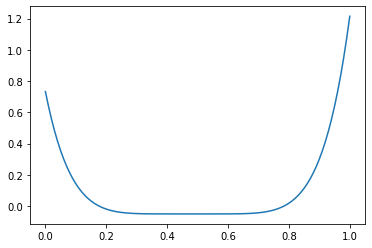

In [77]:
def polynomial(x, x0, x1, a, b):
    return x0 + (a*(x-x1))**b

delta = 0.01
x = np.arange(0, 1+delta, delta)

#x0 = 0.0
#x1 = 0.48
#a  = 5.0
#b  = 7

x0 = -0.05
x1 = 0.48
a  = 2
b  = 6

plt.plot(x , polynomial(x, x0, x1, a, b))


# Polynomial function of the time-stamps
times_norm = polynomial(t, x0, x1, a, b)
times_norm = np.concatenate([times_norm, times_norm])

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)

AUC_PA_sk_time = roc_auc_score(ground_truth, score_list_pa_time)

print("Using scikit-learn AUC function:")
print("- PA Method: ", AUC_PA_sk_time)

Comment

Now we can use our newly optimized polynomial and try to combine both the PA and CN methods once again.

In [73]:
score_list_cn_time = cn_method(adjM_weighted, unconnected_vertex_pairs)

step   = 0.01
a_list = np.arange(0, 1 + step, step)
AUC_save = []

for a in a_list:
    combined_scores_time = a*score_list_cn_time + (1-a)*score_list_pa_time
    AUC = roc_auc_score(ground_truth, combined_scores_time)
    AUC_save.append([a, AUC])

AUC_save = np.array(AUC_save)

max_AUC_pos = AUC_save[:,1].argmax()

print("Found max AUC",AUC_save[max_AUC_pos, 1],"for a =",AUC_save[max_AUC_pos, 0])

Found max AUC 0.8182425580621437 for a = 0.96


Using both the time weights and the combined CN and PA method, we get our best result yet.

# Running on the competition data (2017)

In [ ]:
# The concatenation is used to produce a symmetric adjacency matrix
data_rows = np.concatenate([full_dynamic_graph_sparse[:, 0], full_dynamic_graph_sparse[:, 1]])
data_cols = np.concatenate([full_dynamic_graph_sparse[:, 1], full_dynamic_graph_sparse[:, 0]])
data_ones = np.ones(len(data_rows), np.uint32)

# Normalizing the time-stamps
times = full_dynamic_graph_sparse[:, 2]
t     = times/times.max()

# Polynomial function of the time-stamps

x0 = -0.05
x1 = 0.48
a  = 2
b  = 7

times_norm = polynomial(t, x0, x1, a, b)
times_norm = np.concatenate([times_norm, times_norm])

# Building unweighted adjacency matrix
adjM = ss.csr_matrix((data_ones, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

# Building the weighted adjacency matrix
adjM_weighted = ss.csr_matrix((times_norm, (data_rows, data_cols)), shape=(NUM_OF_VERTICES, NUM_OF_VERTICES))

In [ ]:
#score_list_l3 = l3_method(adjM, unconnected_vertex_pairs)
#score_list_cn = cn_method(adjM, unconnected_vertex_pairs)
#score_list_pa = pa_method(adjM, unconnected_vertex_pairs)

score_list_cn_time = cn_method(adjM_weighted, unconnected_vertex_pairs)
score_list_pa_time = pa_method(adjM_weighted, unconnected_vertex_pairs)

a = 0.94

combined_scores_time = a*score_list_cn_time + (1-a)*score_list_pa_time

sorted_prediction = np.argsort(-1.0*combined_scores_time)

# Exporting a submission file

In [ ]:
import json

# Current submissions done:
# Bacalhau à Brás - L3 method unweighted
# Bacalhau com Todos - PA method unweighted
# Bacalhau à Gomes de Sá - CN + PA method unweighted
# Bacalhau à Lagareiro - CN + PA method time-weighted - still to be submitted, probably best one yet

# Save the results for submission.
submit_file = "bacalhau_a_lagareiro.json"

all_idx_list_float=list(map(float, sorted_predictions))
with open(submit_file, "w", encoding="utf8") as json_file:
    json.dump(all_idx_list_float, json_file)
    
print("Solution stored as "+submit_file+".\nLooking forward to your submission.")